In [11]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from basenji import seqnn, stream
import json
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
import seaborn as sns

from akita_utils.dna_utils import dna_1hot
from akita_utils.numpy_utils import ut_dense
from akita_utils.seq_gens import (
    symmertic_insertion_seqs_gen,
    reference_seqs_gen,
)
from akita_utils.tsv_utils import (
    add_orientation,
    add_background,
    add_const_flank_and_diff_spacer,
)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# arguments 
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

# table with CTCF sites
CTCT_table = "./random_10sites.tsv"

# path to the model and params file
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

### Loading the model

In [5]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Adding insertion parameters

In [6]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [7]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")[1:2].reset_index(drop=True)
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]
seq_coords_df["seq_index"] = [0]

# insertion parameters
flank_length = 30
orient_list = [">>", "<<", "><", "<>"]
background_indices_list = [x for x in range(10)]
# inter-motif distance: 60, 100kb, 200kb, 400kb, 700kb
spacing_list=[0, 49970, 99970, 199970, 349970]

# adding orientation
seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
seq_coords_df = add_background(
    seq_coords_df, 
    background_indices_list
    )

seq_coords_df = add_const_flank_and_diff_spacer(
        seq_coords_df, 
        flank_length, 
        spacing_list
        )

### Predictions for (references) background sequences

In [8]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

num_insert_backgrounds = 1

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [9]:
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 11s 2s/step


### Predictions for insertions

In [10]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [12]:
num_experiments = len(seq_coords_df)

summary_matrix = np.zeros((3, 4, 5, 6, 10, 130305))
# seq_index, orient_index, spacer_index, target_index, bg_index

In [13]:
for exp_index in range(num_experiments):
    
    print(f"experiment {exp_index}")

    seq_index = seq_coords_df.iloc[exp_index].seq_index
    orient = seq_coords_df.iloc[exp_index].orientation
    bg_index = seq_coords_df.iloc[exp_index].background_index
    spacer_index = spacing_list.index(seq_coords_df.iloc[exp_index].spacer_bp)

    if orient == ">>":
        orient_index = 0
    if orient == "<<":
        orient_index = 1    
    if orient == "><":
        orient_index = 2
    elif orient == "<>":
        orient_index = 3
    
    prediction_matrix = preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    difference_matrix = prediction_matrix - reference_prediction_matrix

    for target_index in range(6):
        summary_matrix[seq_index, orient_index, spacer_index, target_index, bg_index, :] += difference_matrix[:,target_index]  

experiment 0
4/4 [==============================] - 36s 9s/step
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
experiment 10
experiment 11
experiment 12
experiment 13
experiment 14
experiment 15
experiment 16
experiment 17
experiment 18
experiment 19
experiment 20
experiment 21
experiment 22
experiment 23
experiment 24
experiment 25
experiment 26
experiment 27
experiment 28
experiment 29
experiment 30
experiment 31
experiment 32
4/4 [==============================] - 36s 9s/step
experiment 33
experiment 34
experiment 35
experiment 36
experiment 37
experiment 38
experiment 39
experiment 40
experiment 41
experiment 42
experiment 43
experiment 44
experiment 45
experiment 46
experiment 47
experiment 48
experiment 49
experiment 50
experiment 51
experiment 52
experiment 53
experiment 54
experiment 55
experiment 56
experiment 57
experiment 58
experiment 59
experiment 60
experiment 61
experiment 62
experiment 63
experiment 6

In [14]:
# averaging over targets and backgrounds
ave_summary_matrix = summary_matrix.mean(axis=(3,4))
# seq_index, orient_index, spacer_index

distance_set = [spacer*2 + 60 for spacer in spacing_list]
orientation_set = ['>>', '<<', '><', '<>']
seq_index = 0

my_coordinates = seq_coords_df[seq_coords_df["seq_index"] == seq_index].iloc[0].chrom + "_" + str(seq_coords_df[seq_coords_df["seq_index"] == seq_index].iloc[0].start) + "-" + str(seq_coords_df[seq_coords_df["seq_index"] == seq_index].iloc[0].end)

plotting: distance=60
plotting: distance=60
plotting: distance=60
plotting: distance=60
plotting: distance=100000
plotting: distance=100000
plotting: distance=100000
plotting: distance=100000
plotting: distance=200000
plotting: distance=200000
plotting: distance=200000
plotting: distance=200000
plotting: distance=400000
plotting: distance=400000
plotting: distance=400000
plotting: distance=400000
plotting: distance=700000
plotting: distance=700000
plotting: distance=700000
plotting: distance=700000


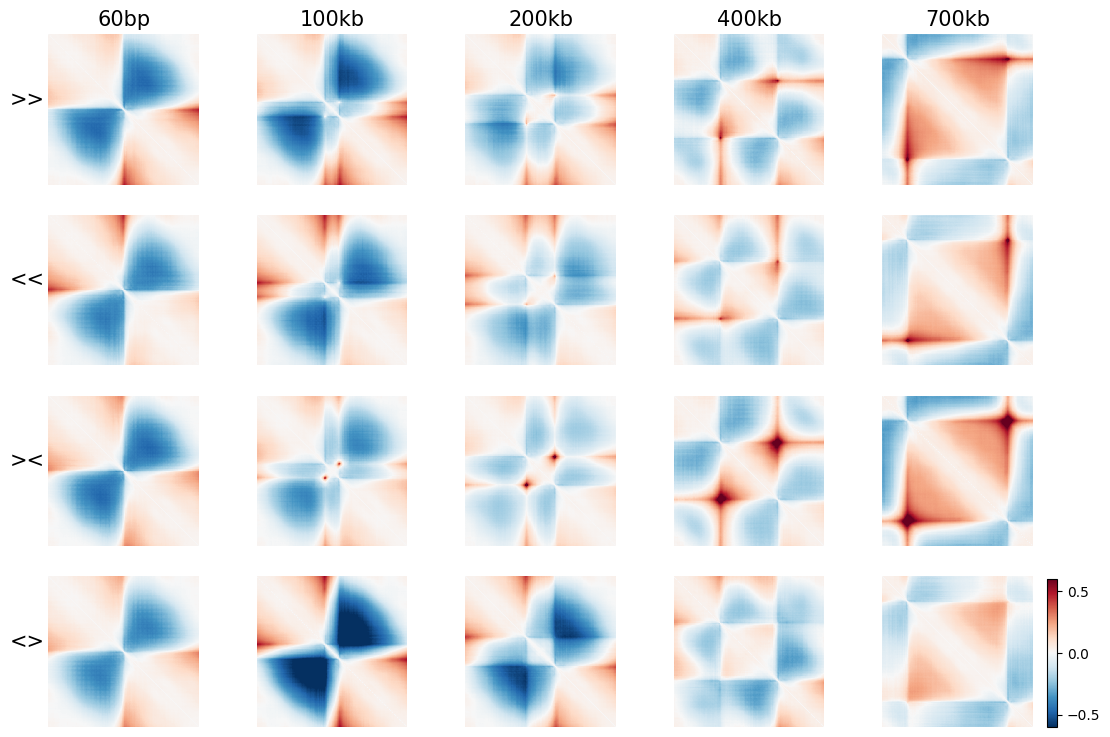

In [16]:
rows = [orientation for orientation in orientation_set]
cols = ["60bp", "100kb", "200kb", "400kb", "700kb"]

fig, axs = plt.subplots(len(orientation_set), len(distance_set), figsize=(13,9))

for spacer_idx in range(len(distance_set)):
    for orient_idx in range(len(orientation_set)):
        print(f"plotting: distance={distance_set[spacer_idx]}")
        
        plot_matrix = ut_dense(np.expand_dims(ave_summary_matrix[seq_index, orient_idx, spacer_idx, :], 1), diagonal_offset=2)
        plot_matrix = np.squeeze(plot_matrix, axis=2)
        vmin = -0.6
        vmax = 0.6
        
        sns.heatmap(
            plot_matrix,
            ax=axs[orient_idx, spacer_idx],
            center=0,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="RdBu_r",
            square=True,
            xticklabels=False,
            yticklabels=False,
        )

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=15)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, fontsize=15, labelpad=15)

a = np.array([[-0.6,0.6]])
img = plt.imshow(a, cmap="RdBu_r")

cb_ax = fig.add_axes([0.902, 0.110, 0.008, 0.165])
cbar = fig.colorbar(img,orientation='vertical',cax=cb_ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(10)

# plt.savefig(f"./plots/{my_coordinates}_spacing_maps.png", format="png", bbox_inches="tight", dpi=300)

plt.show()

In [17]:
genome_open.close()